In [3]:
# установим библиотеки
import pandas as pd
import numpy as np

# Matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Internal python tool for setting figure size
from IPython.core.pylabtools import figsize

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',  16)

Загрузим данные для обучения и тестирования

# 1. Загрузка данных и проверка на пропуски

Загрузим данные для обучения и тестирования

In [5]:
df = pd.read_csv('data/day.csv')

Посмотрим данные, наименование, тип количество

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Все данные числовые, на первый взгляд пропусков нет. Но посмотрим описательную статистику

In [7]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Явных отклонений не обнаруживается, можно переходить к анализу данных

# Анализ данных: 
Исследуем сезонные и временные паттерны в данных о прокате велосипедов. Построим графики зависимости спроса на велосипеды от погодных условий, времени суток и дня недели. 


## Целевая переменная и распределение

Примем нашей целевой переменной столбец 'cnt': общее количество арендованных велосипедов как зарегистрированными, так и случайными клиентами.
Посмотрим распределение

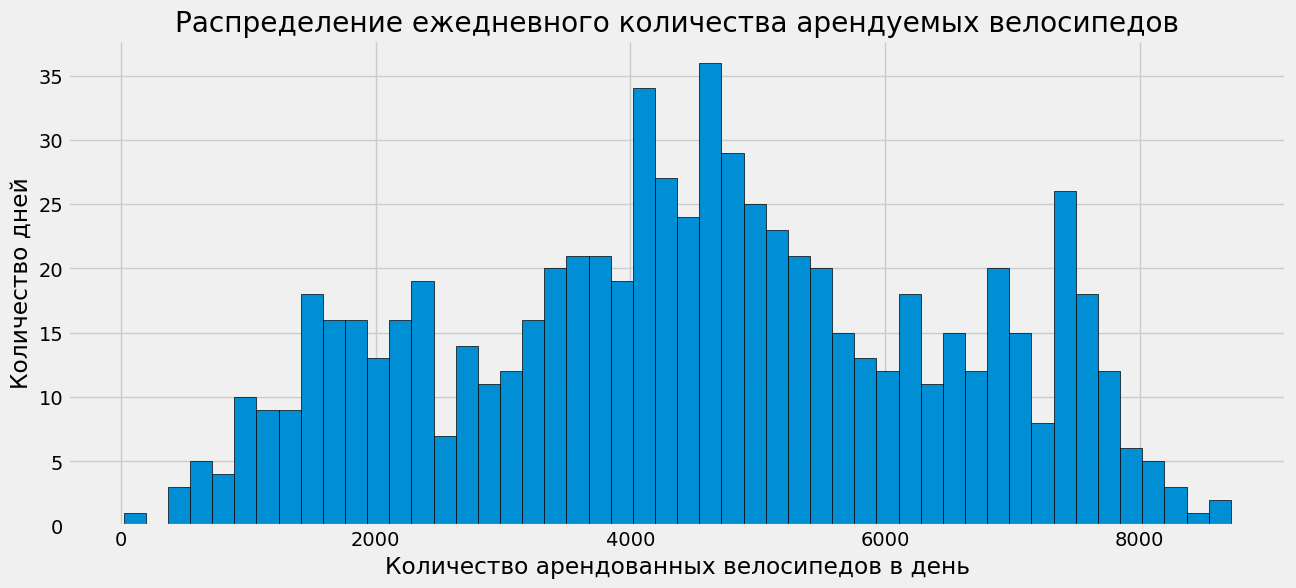

In [8]:
figsize(14, 6)

# Гистограмма по количеству арендованных велосипедов
plt.style.use('fivethirtyeight')
plt.hist(df['cnt'], bins=50, edgecolor='k')
plt.xlabel('Количество арендованных велосипедов в день')
plt.ylabel('Количество дней')
plt.title('Распределение ежедневного количества арендуемых велосипедов')
plt.show()

Распределение отдаденно напоминает нормальное. Есть некоторые выбросы в начале и конце. На минимуме, возможно это были случайные арендаторы в "нелетную" погоду. В конце видимо какие то праздники с экстримальным количеством арендаторов.

Посмотрим "нижнюю" границу

In [9]:
df.loc[df['cnt'] == 22, :]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
667,668,2012-10-29,4,1,10,0,1,1,3,0.44,0.4394,0.88,0.3582,2,20,22


29 октября, легкий снег или дождь, видимо действительно "экстрималы". Проверим описание без данного значения

In [10]:
df[df['cnt'] > 22]['cnt'].describe()

count     730.000000
mean     4510.489041
std      1931.408300
min       431.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64

Теперь проверим верхнюю границу. Однако учитывая, что по графику видно несколько значений. Выведем "хвост" отсортированного списка

In [11]:
df['cnt'].sort_values(ascending=False).head(10)

623    8714
637    8555
630    8395
447    8362
504    8294
617    8227
571    8173
629    8167
643    8156
518    8120
Name: cnt, dtype: int64

Видно, что 2(два) верхних значения отстоят от остальной выборки.
Для чистоты эксперимента удалим "экстримальные значения сверху и снизу.

In [12]:
# Обозначим минимум второе минимальное значение
min_ = df['cnt'].sort_values(ascending=True).iloc[1]
# Обозначим максимум второе максимальное значение
max_ = df['cnt'].sort_values(ascending=False).iloc[1]
# Удалим значения вне диапазона
df = df[(df['cnt'] > min_) & (df['cnt'] < max_)]
#выведем описания для проверки
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,365.321871,2.493810,0.499312,6.515818,0.028886,2.990371,0.685007,1.394773,0.495654,0.474522,0.627756,0.190231,844.911967,3659.843191,4504.755158
std,210.615073,1.109514,0.500344,3.450470,0.167601,2.002386,0.464833,0.542543,0.183148,0.163065,0.142385,0.077368,678.645023,1550.102039,1917.270612
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,9.000000,432.000000,441.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,316.500000,2503.500000,3176.500000
50%,365.000000,2.000000,0.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180967,713.000000,3662.000000,4548.000000
75%,546.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655833,0.609859,0.730209,0.233206,1094.500000,4756.500000,5929.500000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8395.000000


Проверим, что получилось

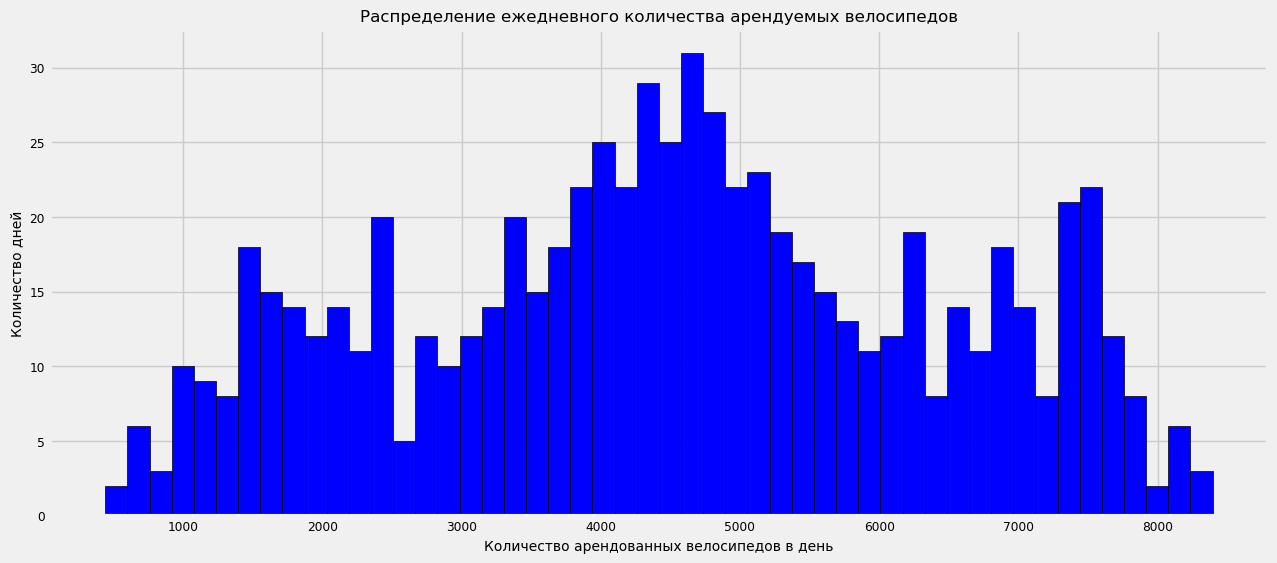

In [31]:
figsize(14, 6)

# Гистограмма по количеству арендованных велосипедов
plt.style.use('fivethirtyeight')
plt.hist(df['cnt'], bins=50, edgecolor='k', color = 'b')
plt.xlabel('Количество арендованных велосипедов в день', fontsize = 10)
plt.ylabel('Количество дней', fontsize = 10)
plt.title('Распределение ежедневного количества арендуемых велосипедов', fontsize = 12)
plt.show()

Граничные значения убрали. Распределение близко к нормальному. Видно, что есть некоторые всплески, возможно связанные с сезонностью или иными факторами.

## Исследуем зависимости от сезона, месяца, дня недели

Посмотрим зависимость количества аренд от сезона, месяца, дня недели и типа дня (праздник или будни)

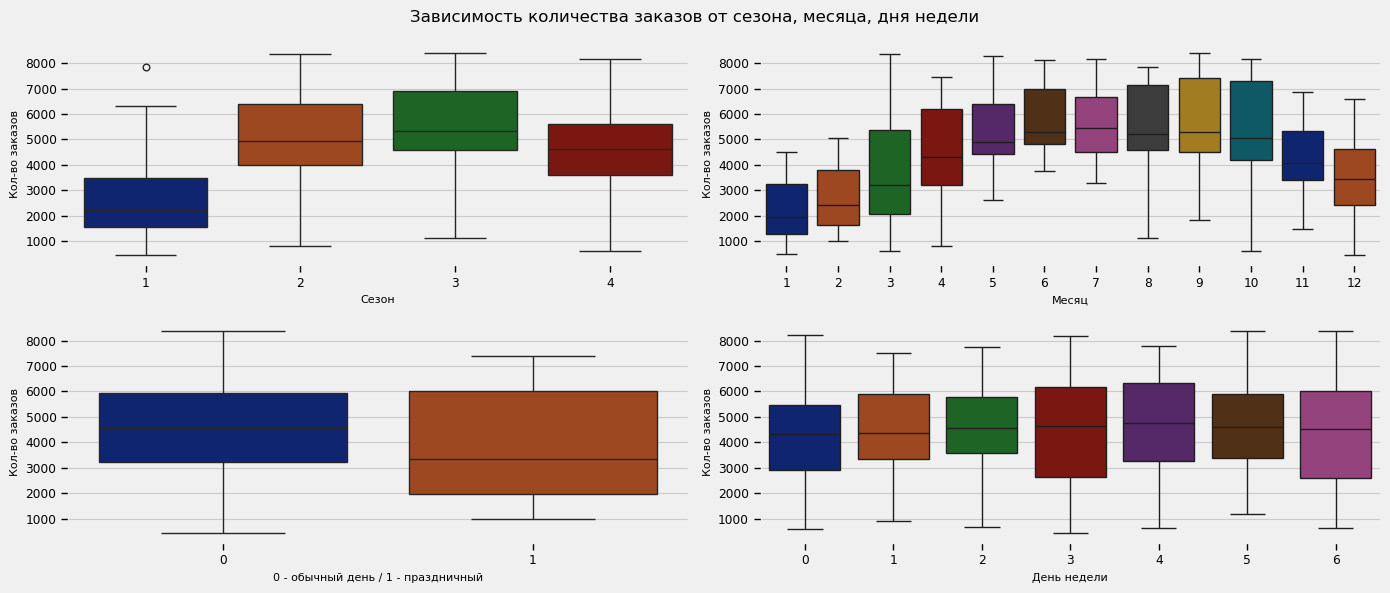

In [36]:
fig, axes = plt.subplots(2, 2)
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})

sns.boxplot(data=df, x = 'season', y='cnt', hue = 'season', legend=False, ax=axes[0,0], palette='dark').set(xlabel = 'Сезон', ylabel = 'Кол-во заказов')
sns.boxplot(data=df, x ='mnth', y='cnt', hue = 'mnth', legend=False, ax=axes[0,1], palette='dark').set(xlabel = 'Месяц', ylabel = 'Кол-во заказов')
sns.boxplot(data=df, x ='holiday', y='cnt', hue = 'holiday', legend=False, ax=axes[1,0], palette='dark').set(xlabel = '0 - обычный день / 1 - праздничный', ylabel = 'Кол-во заказов')
sns.boxplot(data=df, x ='weekday', y='cnt', hue = 'weekday', legend=False, ax=axes[1,1], palette='dark').set(xlabel = 'День недели', ylabel = 'Кол-во заказов')

fig.suptitle('Зависимость количества заказов от сезона, месяца, дня недели')
plt.tight_layout()
plt.show()

Видно, что имеется четкая зависимость от сезона/месяца, а также от дня недели и типа дня - праздник или обычный. Хотя по последним двум нужно посмотреть более подробно.

Давайте посмотрим совместный график по дням недели и по типу дня:

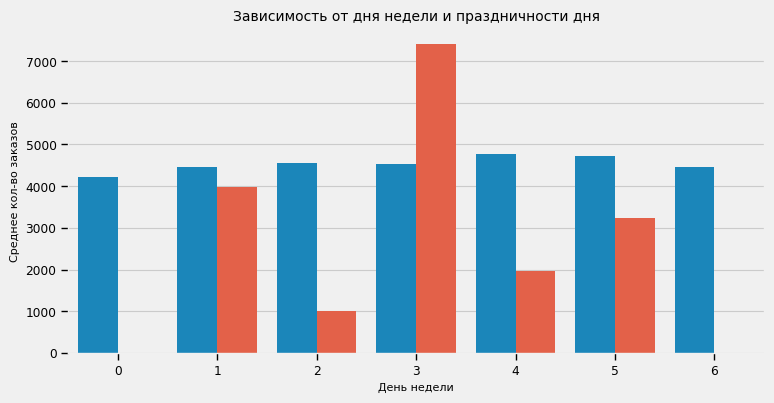

In [15]:
figsize(8, 4)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":10,"axes.labelsize":8})

sns.barplot(x="weekday", 
            y="cnt", 
            hue="holiday", 
            ci=None, 
            data=df, 
            legend=False
           ).set(xlabel = 'День недели', 
                 ylabel = 'Среднее кол-во заказов', 
                 title = 'Зависимость от дня недели и праздничности дня')

plt.show()

Видно что распределение по "обычным" дням недели почти равномерно. Также видно что праздники не приходятся на понедельники и воскресения. А также видно, что в количество заказов очень зависит от того на какой день недели выпадает праздник. Если он попадает на среду, количество заказов по сравнению с обычным днем увеличивается, если на другие дни то уменьшается.

И, для полноты картины, построим графики распределения для дней недели

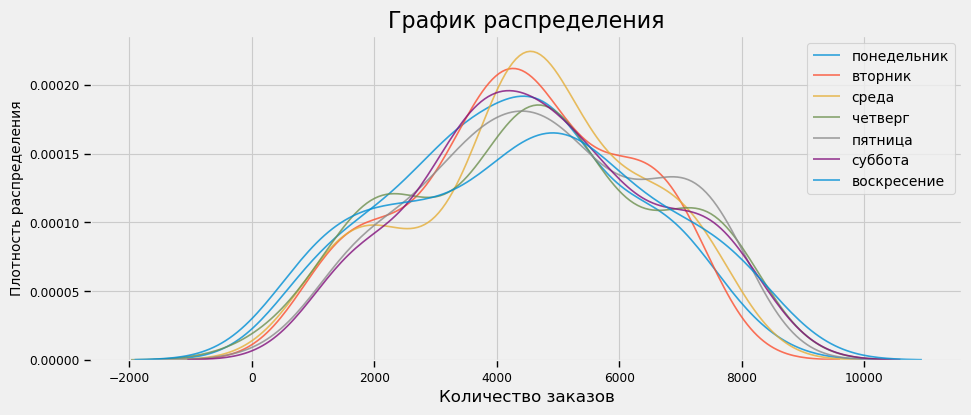

In [16]:
figsize(10, 4)

# Построим график для каждого дня недели
weekdays = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресение']
for i in range(7):
    subset = df[df['weekday'] == i]

    # График плотности
    sns.kdeplot(subset['cnt'], label = weekdays[i], fill = False, alpha = 0.8)


plt.xlabel('Количество заказов', size = 12)
plt.ylabel('Плотность распределения', size = 10)
plt.title('График распределения', size = 16)
plt.legend(fontsize = 10)
plt.show()

Хотя и небольшая, но все же разница есть. График для среды например явно выделяется среди других. 

**Некоторые промежуточные выводы:**

Как и предполагалось изначально, количество заказ на аренду велосипедов имеет зависимость от сезона, месяца, дня недели и типа дня (праздичный или будничный). Соответсвенно мы будем включать все эти параметры в нашу последующую модель.

## Исследуем влияние погодных условий

Погодные условия представлены параметрами:
- тип погоды (weathersit): 1: Ясно, малооблачно; - 2: Пасмурно, облачно; - 3: Легкий снег или дождь; - 4: Сильный дождь или снег, град;
- температура (temp): нормализованная температура, получена как деление на 41 градус Цельсия, взята как максимум;
- ощущаемая температура (atemp): aнормализованная температура, получена как деление на 50 градусов Цельсия, взята как максимум;
- влажность(hum): 
 нормализованная влажность. Значения поделены на 100 (максимум);
- скорость ветр(windspeed): winнормализована. Поделена на 67 (максимум).67 (max)

### Тип погоды - weathersit

Первый параметр по сути является категориальным признаком, так как представлен всего четырьмя значениями. Построим boxplot чтобы посмотреть как распределяется количество аренд в зависимости от погоды

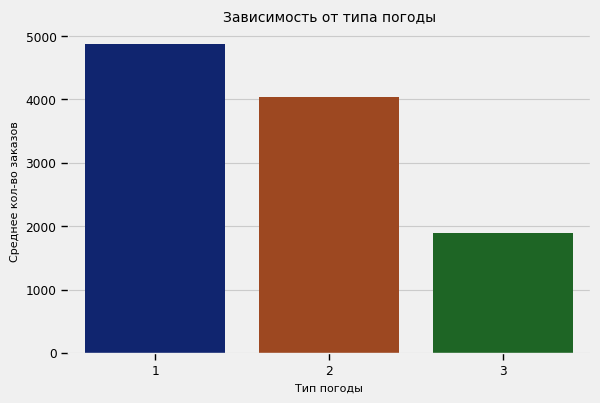

In [18]:
figsize(6, 4)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":10,"axes.labelsize":8})

sns.barplot(x="weathersit", 
            y="cnt", 
            hue="weathersit", 
            ci=None, 
            data=df, 
            legend=False, 
            palette='dark'
           ).set(xlabel = 'Тип погоды', 
                 ylabel = 'Среднее кол-во заказов', 
                 title = 'Зависимость от типа погоды')
plt.show()

Очевидно, что чем хуже погода, тем меньше желающих покататься на велосипедах.

### Температура, влажность и ветер

Посмотрим теперь на графики распределения количества аренд в зависимости от температуры, влажности и скорости ветра. Учитывая, что эти величины непрерывные, то лучше будет построить графики типа scatterplot

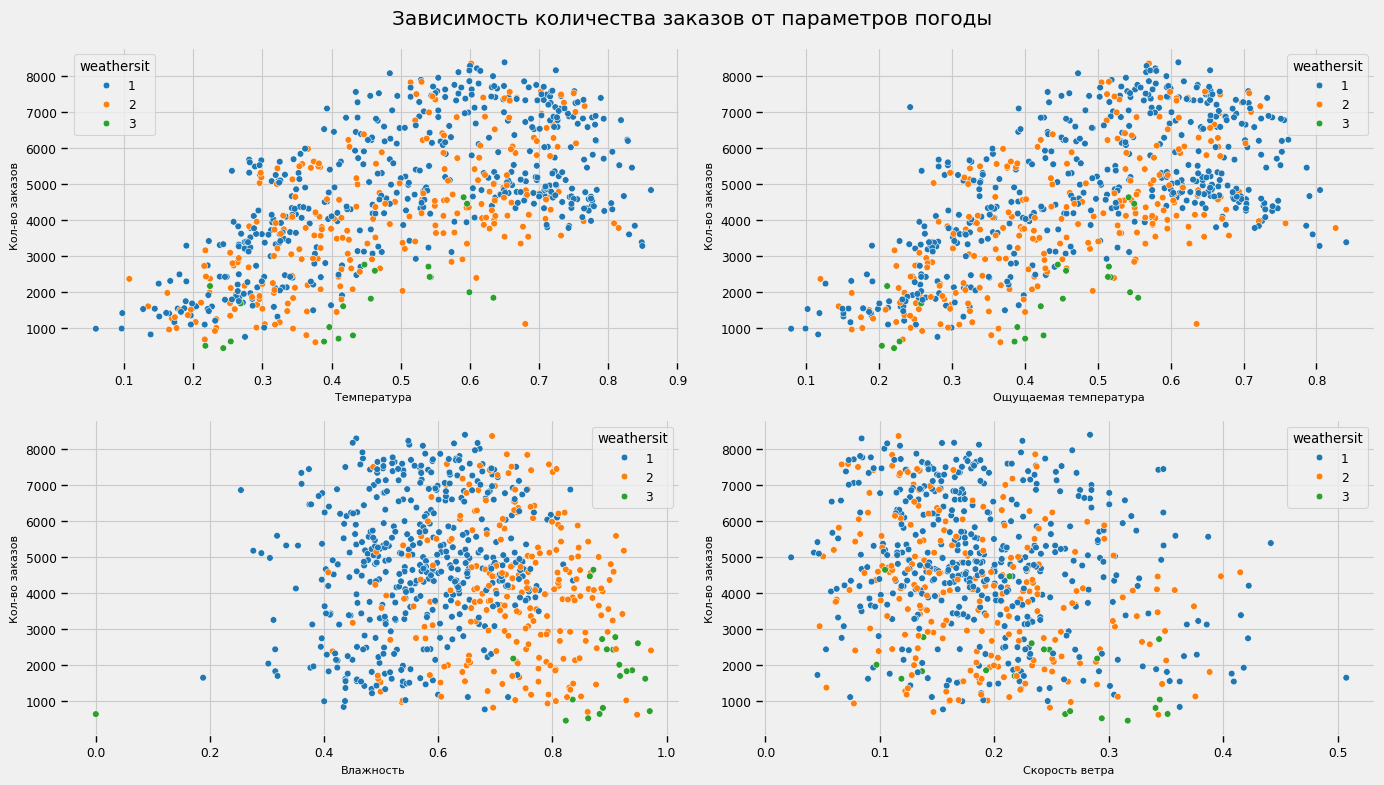

In [48]:
figsize(14, 8)
fig, axes = plt.subplots(2, 2)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":10,"axes.labelsize":8})

sns.scatterplot(data=df, x = 'temp', y='cnt', hue = 'weathersit', ax=axes[0,0], palette='tab10').set(xlabel = 'Температура', ylabel = 'Кол-во заказов')
sns.scatterplot(data=df, x = 'atemp', y='cnt', hue = 'weathersit', ax=axes[0,1], palette='tab10').set(xlabel = 'Ощущаемая температура', ylabel = 'Кол-во заказов')
sns.scatterplot(data=df, x = 'hum', y='cnt', hue = 'weathersit', ax=axes[1,0], palette='tab10').set(xlabel = 'Влажность', ylabel = 'Кол-во заказов')
sns.scatterplot(data=df, x = 'windspeed', y='cnt', hue = 'weathersit', ax=axes[1,1], palette='tab10').set(xlabel = 'Скорость ветра', ylabel = 'Кол-во заказов')

fig.suptitle('Зависимость количества заказов от параметров погоды')
plt.tight_layout()
plt.show()

**Некоторые промежуточные выводы:**

Первое, что хотелось бы отметить - temp atemp сильно коррелированы между собой и соответвенно для модели можно выбрать только один из них.

Второе, очевидно, что чем комфортнее погодные условия, тем больше заказов на аренду. Это касается как температуры, так и влажности и скрор

### Проверка изменений по году ведения статистики

Посмотрим есть ли разница между годами ведения статистики (рост или падение)

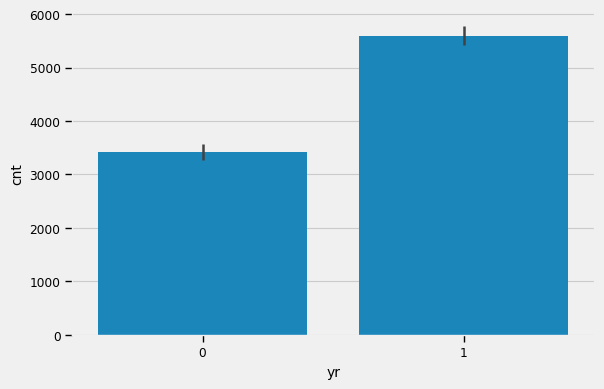

In [42]:
figsize(6, 4)

sns.barplot(data = df, x="yr", y="cnt")
plt.show()

Видно, что разница есть и у ребят есть весьма хороший рост от года 0 к году 1

### Корреляция

Рассчитаем корреляции исходных параметров относительно нашей целевой переменной

In [66]:
# уберем лишние колонки не несущие смысла
data = df.drop(['instant', 'dteday', 'casual', 'registered'], axis = 1)
correlations_data = data.corr()['cnt'].sort_values()
print(correlations_data)

weathersit   -0.291733
windspeed    -0.238235
hum          -0.090953
holiday      -0.069291
weekday       0.057958
workingday    0.075097
mnth          0.278868
season        0.408167
yr            0.570120
temp          0.628790
atemp         0.632407
cnt           1.000000
Name: cnt, dtype: float64


Проверим, не улучшится ли корреляция если мы применим некоторые преобразования к числовым параметрам

In [67]:
# Создадим колонки к квадратами, корнями и логарифмами
for col in data.columns:
    # пропускаем целевую переменую
    if col == 'cnt':
        next
    else:
        data['sqrt_' + col] = np.sqrt(data[col])
        data['log_' + col] = np.log(data[col])

C:\My_programs\Anaconda\envs\learn\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\My_programs\Anaconda\envs\learn\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\My_programs\Anaconda\envs\learn\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\My_programs\Anaconda\envs\learn\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\My_programs\Anaconda\envs\learn\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
# посчитаем корреляцию снова
correlations = data.corr()['cnt'].sort_values()
# выведем первые 10 значений
correlations.head(15)

weathersit        -0.291733
sqrt_weathersit   -0.285053
log_weathersit    -0.278646
windspeed         -0.238235
sqrt_windspeed    -0.227579
log_windspeed     -0.209133
hum               -0.090953
holiday           -0.069291
sqrt_holiday      -0.069291
log_hum           -0.068579
sqrt_hum          -0.059520
log_weekday        0.038248
weekday            0.057958
sqrt_weekday       0.066630
sqrt_workingday    0.075097
Name: cnt, dtype: float64

In [69]:
# и последние 10 значений
correlations.tail(15)

log_mnth          0.416234
sqrt_season       0.448443
log_season        0.483994
sqrt_yr           0.570120
yr                0.570120
temp              0.628790
atemp             0.632407
sqrt_temp         0.647599
sqrt_atemp        0.648618
log_atemp         0.654462
log_temp          0.655761
cnt               1.000000
log_yr                 NaN
log_holiday            NaN
log_workingday         NaN
Name: cnt, dtype: float64

Преобразования не изменили значимо отношения. Видно что наша целевая переменная больше всего зависит от температуры, сезона, месяца, типа погоды и ветра.